# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [13]:
 # define your regions here
presel = {
        "mu": {
            "tagger>0.5": "THWW>0.5",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>35",            
        },
        "ele": {
            "tagger>0.5": "THWW>0.5",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>55",
        },
}

from make_stacked_hists_tagger import make_events_dict
channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",    
    "Data",
    "WZQQorDYJets"
]

samples_dir = {
    "2016":    "../eos/May31_hww_2016",
    "2016APV": "../eos/May31_hww_2016APV",
    "2017":    "../eos/May31_hww_2017",    
    "2018":    "../eos/May31_hww_2018", 
}

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [14]:
events_dict = {}

In [15]:
taggers = [
#     "v2_nor2",     # old signal samples (irreproducible)
    
#     "v35_12_14",     # new signal samples (more reproducible)

#     "v35_16",    # new signal samples (very reproducible) 15 epochs
#     "v35_17",    # new signal samples (very reproducible) 15 epochs
    
#     "v35_20",    # new signal samples (very reproducible) 25 epochs
#     "v35_23",    # new signal samples (very reproducible) 25 epochs
#     "v35_26",    # new signal samples (very reproducible) 25 epochs
#     "v35_29",    # new signal samples (very reproducible) 25 epochs
    
    
    # with in-memory
#     "v35_21",    # new signal samples (very reproducible)
#     "v35_22",    # new signal samples (very reproducible)
#     "v35_23",    # new signal samples (very reproducible)
    
    
#     "v35_24",    # new signal samples (very reproducible)
    
    
    "v35_30",   # 60:40 split 20 epochs
#     "v35_31",   # 60:40 split 30 epochs
#     "v35_32",   # 60:40 split 40 epochs

]


for year in years:
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, taggers)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1745 events
INFO:root:Will fill the VBF dataframe with the remaining 854 events
INFO:root:tot event weight 7.6048678973173125 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 87 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1 events
INFO:root:tot event weight 1.6639318904239442 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1953 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 127 events
INFO:root:tot event weight 38.74263155700244 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine th

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 762441 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 5455 events
INFO:root:tot event weight 28.786086262476736 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 9636 events
INFO:root:Will fill the SingleTop dataframe with the remaining 149 events
INFO:root:tot event weight 4.596566146139161 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 137227 events
INFO:root:Will fill the TTbar dataframe with the remaining 2822 events
INFO:root:tot event weight 97.38897248323246 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applyi

INFO:root:Will fill the EWKvjets dataframe with the remaining 174 events
INFO:root:tot event weight 53.909065748352205 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 5565 events
INFO:root:Will fill the WH dataframe with the remaining 2727 events
INFO:root:tot event weight 1.8656891445755954 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 158739 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 13751 events
INFO:root:tot event weight 776.2600367463306 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 412828 events

INFO:root:Will fill the TTbar dataframe with the remaining 2436 events
INFO:root:tot event weight 82.47251591511426 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 147 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 2 events
INFO:root:tot event weight 0.07660557513593472 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 129 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1 events
INFO:root:tot event weight 0.425185533433758 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 120 events
INFO:root:Will fill the Diboson dataframe with the remaining 11 events
INFO:root:tot event weight

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 43264 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2704 events
INFO:root:tot event weight 152.51758673087812 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 357653 events
INFO:root:Will fill the TTbar dataframe with the remaining 9758 events
INFO:root:tot event weight 444.10789401490615 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying tagger>0.5 selection on 18103 events
INFO:root:Will fill the Data dataframe with the remaining 857 events
INFO:root:tot event weight 857.0 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stor

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 405 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 33 events
INFO:root:tot event weight 3.3037182379481824 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 212 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 7 events
INFO:root:tot event weight 0.4797731420574371 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 112129 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 843 events
INFO:root:tot event weight 2.934070794122016 

INFO:root:Finding EWKWminus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event w

INFO:root:Applying tagger>0.5 selection on 91268 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5966 events
INFO:root:tot event weight 73.29637065870591 

INFO:root:Finding EWKZ_ZToLL samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 168 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 11 events
INFO:root:tot event weight 3.0380730285745834 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 5582 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 284 events
INFO:root:tot event weight 156.39884352372158 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1861 events
INFO:root:Wi

INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 19 events
INFO:root:tot event weight 4.27496389236216 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 38503 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1386 events
INFO:root:tot event weight 0.3271751430167651 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 6739 events
INFO:root:Will fill the ttH dataframe with the remaining 1424 events
INFO:root:tot event weight 1.977456952818943 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 1060 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 36 ev

INFO:root:Will fill the WH dataframe with the remaining 750 events
INFO:root:tot event weight 0.913194431377892 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 29709 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 867 events
INFO:root:tot event weight 39.74838113379472 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 45 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 4 events
INFO:root:tot event weight 0.3617577329402102 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 4584 events
INFO:root:Will fill the SingleTop dataframe with the re

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 5480 events
INFO:root:Will fill the ZH dataframe with the remaining 2118 events
INFO:root:tot event weight 0.02280585108129316 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 386 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 27 events
INFO:root:tot event weight 3.0653232389670064 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 48 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding WJetsToLNu_HT-400To600 sa

INFO:root:Will fill the EWKvjets dataframe with the remaining 3 events
INFO:root:tot event weight 0.33752119026068317 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 7282 events
INFO:root:Will fill the SingleTop dataframe with the remaining 145 events
INFO:root:tot event weight 0.5982306970722233 

INFO:root:Finding SingleElectron_Run2016F_HIPM samples and should combine them under Data
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-50To100 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 2058 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 143 events
INFO:root:tot event weight 15.719890768518223 

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagg

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 28 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1 events
INFO:root:tot event weight 0.6573389184253016 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 17843 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1556 events
INFO:root:tot event weight 788.9972982373508 

INFO:root:Finding SingleMuon_Run2016C_HIPM samples and should combine them under Data
INFO:root:Applying tagger>0.5 selection on 6972 events
INFO:root:Will fill the Data dataframe with the remaining 413 events
INFO:root:tot event weight 413.0 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 5636 events
INFO:root:Will fill the ZH dataframe 

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 595 events
INFO:root:Will fill the Diboson dataframe with the remaining 70 events
INFO:root:tot event weight 74.16132808198391 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 710489 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 5450 events
INFO:root:tot event weight 43.729386938900696 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 12290 events
INFO:root:Will fill the SingleTop dataframe with the remaining 205 events
INFO:root:tot event weight 6.884113070594644 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event

INFO:root:tot event weight 12.690625015672772 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 2473 events
INFO:root:Will fill the VBF dataframe with the remaining 1260 events
INFO:root:tot event weight 16.700830177191825 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 74 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2 events
INFO:root:tot event weight 4.277669431090988 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 2296 events
INFO:root:Will fill the EWKvjets dataframe with the

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 109129 events
INFO:root:Will fill the TTbar dataframe with the remaining 2304 events
INFO:root:tot event weight 117.36269149448287 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 5 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.5 selection on 99 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:

In [16]:
for year in years:
    # electron channel
    df = pd.read_parquet(f"fake_{year}_ele.parquet")
    for selection in presel["ele"]:
        df = df.query(presel["ele"][selection])

    events_dict[year]["ele"]["Fake"] = df
    
    # muon channel
    events_dict[year]["mu"]["Fake"] = 0

In [18]:
taggerss = ["fj_ParT_score"]
for tagger in taggers:
    taggerss.append(f"fj_ParT_score_finetuned_{tagger}")

In [32]:
signals = ["VBF", "ggF", "ttH", "WH", "ZH"]

# tagger_cuts = np.linspace(0.8, 0.97, 30)
tagger_cuts = np.linspace(0.8, 1, 61)

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["ele"]

s_over_b = {}

den, num = 0, 0

taggers_to_plot = [
    "fj_ParT_score",
    "THWW",
#     "fj_ParT_score_finetuned_v35_12_14",
    
#     "fj_ParT_score_finetuned_v35_16",
#     "fj_ParT_score_finetuned_v35_17",
#     "fj_ParT_score_finetuned_v35_20",    
    
#     "fj_ParT_score_finetuned_v35_23",
#     "fj_ParT_score_finetuned_v35_26",
#     "fj_ParT_score_finetuned_v35_29",
    
#     "fj_ParT_score_finetuned_v35_24",
#     "fj_ParT_score_finetuned_v35_30",
#     "fj_ParT_score_finetuned_v35_31",
#     "fj_ParT_score_finetuned_v35_32",    
    

#     "fj_ParT_score_finetuned_v35_12_14 metcut",

#     "fj_ParT_score_finetuned_v35_12_14 met>25",
#     "fj_ParT_score_finetuned_v35_12_14 met>30",
#     "fj_ParT_score_finetuned_v35_12_14 met>35",
#     "fj_ParT_score_finetuned_v35_12_14 met>40",
#     "fj_ParT_score_finetuned_v35_12_14 met>45",
#     "fj_ParT_score_finetuned_v35_12_14 met>50",
#     "fj_ParT_score_finetuned_v35_12_14 met>55",
#     "fj_ParT_score_finetuned_v35_12_14 met>60",    
]

add_vbfcut = 0
add_ggFcut = 1

for tagger in taggers_to_plot:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts[:-3]:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample =="Data":
                        continue
                        
                    if (ch=="mu") and (sample =="Fake"):
                        continue                        
                    
                    df = events_dict[year][ch][sample]
                    
                    df = df[df[tagger]>tagger_cut]

                    df = df[(df["n_bjets_T"]==0)]                    

                    # add mass window 
                    mass_window = [100, 150]
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
                                            
                    #add vbf cut
                    if add_vbfcut:
                        df = df[(df["mjj"]>1000) & (df["deta"]>3.5)]
                    if add_ggFcut:
                        df = df[(df["mjj"]<1000) | (df["deta"]<3.5)]

                    ##############################    
                    if sample in signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        if b <= 0:
            b = 1
            
        if s/math.sqrt(b)>3:
            s_over_b[tagger].append(0)
        else:
            s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.8
tagger cut 0.8033333333333333
tagger cut 0.8066666666666668
tagger cut 0.81
tagger cut 0.8133333333333334
tagger cut 0.8166666666666667
tagger cut 0.8200000000000001
tagger cut 0.8233333333333334
tagger cut 0.8266666666666667
tagger cut 0.8300000000000001
tagger cut 0.8333333333333334
tagger cut 0.8366666666666667
tagger cut 0.8400000000000001
tagger cut 0.8433333333333334
tagger cut 0.8466666666666667
tagger cut 0.8500000000000001
tagger cut 0.8533333333333334
tagger cut 0.8566666666666667
tagger cut 0.86
tagger cut 0.8633333333333334
tagger cut 0.8666666666666667
tagger cut 0.87
tagger cut 0.8733333333333334
tagger cut 0.8766666666666667
tagger cut 0.88
tagger cut 0.8833333333333333
tagger cut 0.8866666666666667
tagger cut 0.89
tagger cut 0.8933333333333333
tagger cut 0.8966666666666667
tagger cut 0.9
tagger cut 0.9033333333333333
tagger cut 0.9066666666666667
tagger cut 0.91
tagger cut 0.9133333333333333
tagger cut 0.9166666666666667
tagger cut 0

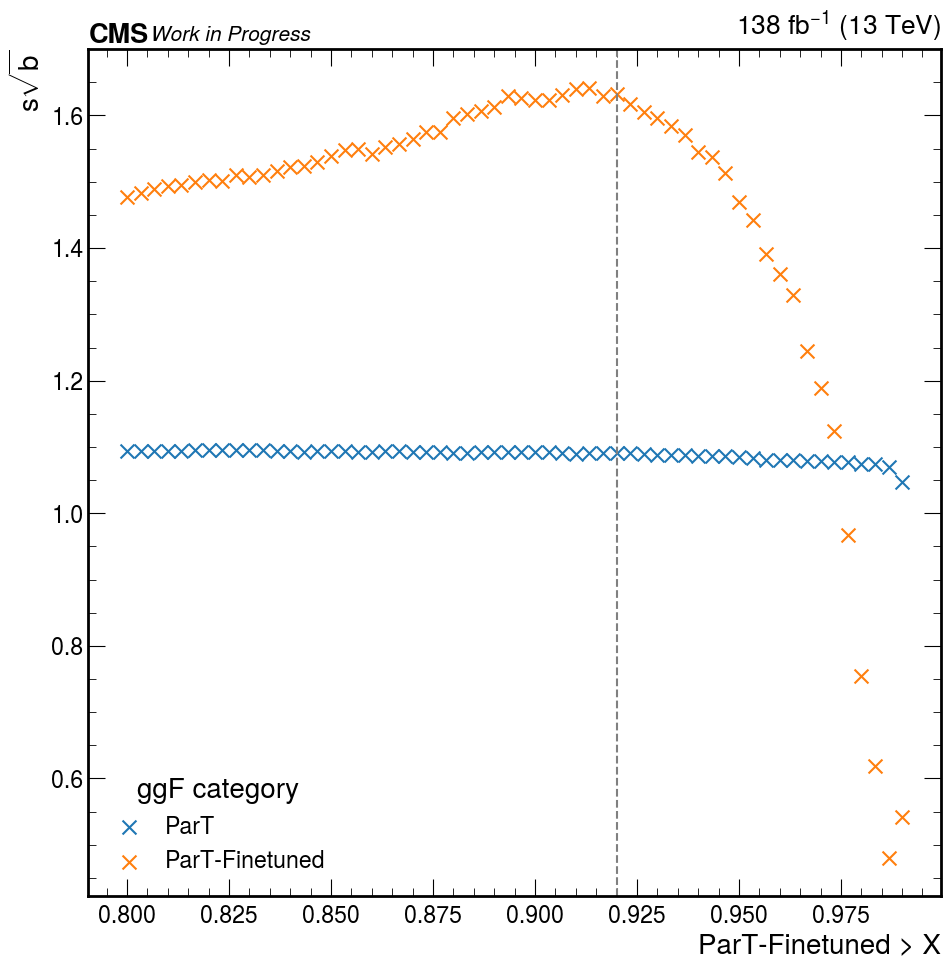

In [33]:
plt.rcParams.update({"font.size": 20})

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

fig, ax = plt.subplots(figsize=(11, 11))

taggers_to_plot = [
    "fj_ParT_score",
    "THWW",    
]
# taggers_to_plot = taggerss

for tagger in taggers_to_plot:   
    
    
    if tagger == "fj_ParT_score":
        lab = "ParT"
        col = "tab:orange"

    elif tagger == "THWW":
        lab = "ParT-Finetuned"


    
    elif tagger == "fj_ParT_score_finetuned_v35_12_14 metcut":
        lab = "ParT-Finetuned (after MET cuts)"        
        
    else:
        lab = tagger
        col = "tab:blue"
        
    
    ax.scatter(tagger_cuts[:-3], s_over_b[tagger], marker="x", s=100, label=lab)#, c=col)

if len(channels)==1:
    lab = f"{nice_ch[channels[0]]} channel"
    if add_vbfcut:
        lab += " (VBF category)"
    if add_ggFcut:
        lab += " (ggF category)"        
    ax.legend(title=lab, loc="lower left")    
else:
    if add_vbfcut:
        lab = "VBF category"
    elif add_ggFcut:
        lab = "ggF category"
    else:
        lab = ""
    ax.legend(title=lab, loc="lower left")
ax.set_ylabel(r"$s\sqrt{b}$")
ax.set_xlabel("ParT-Finetuned > X")

# ax.axvline(0.895, linestyle="--", color="grey")
# ax.axvline(0.924, linestyle="--", color="grey")
# ax.axvline(0.91, linestyle="--", color="grey")
ax.axvline(0.92, linestyle="--", color="grey")

# ax.set_ylim(0.5,2)
# ax.set_ylim(0.2,1.1)
# ax.set_xlim(0.78,0.95)

# ax.set_xticks(tagger_cuts)
hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/soverb-new.pdf")

In [74]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [213]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    "rec_higgs_m",    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VBF",
#     "ttH",
#     "WH",
#     "ZH",    
    "QCD",
#     "DYJets",
    "WJetsLNu",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",

#     "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
    
    "WZQQorDYJets"
]

In [214]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
# tagger_cut = 0.97   # VBF
# tagger_cut = 0.975  # ggF

tagger = "fj_ParT_score_finetuned_v35_12_14"
tagger = "fj_ParT_score_finetuned_v35_20"

# tagger_cut = 0.88   # VBF
tagger_cut = 0.91  # ggF

# tagger_cut = 0.895  # ggF

presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
    "SR": f"({tagger}>{tagger_cut}) & (n_bjets_T==0)",   # dummy
    
#     "SR": f"{tagger}>0.965",
#     "SR": f"{tagger}>{tagger_cut}",    
    
#     "Pre-selection": f"(fj_ParT_score_finetuned>0.95) & (fj_msoftdrop>10)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.88) & ({tagger}>0.70) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.8) & (n_bjets_T>0)",
}

categories_sel = {
#     "VBF": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2018", "2017", "2016", "2016APV"]
years = ["2018"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utils

massbin = 10
if "VBF" in categories_sel:
    massbin = 20

for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),            
        )       
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
            storage=hist2.storage.Weight(),            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
                df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
                if sample == "QCD":
                    threshold = 30
                    den += len(df['event_weight'])
                    num += sum(df["event_weight"]>threshold)

                    df = df[df["event_weight"] < threshold]
                
                x = df[var]
                w = df["event_weight"]
                
                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Removing 0 out of 11 qcd events by applying event_weight<30 (0.00%)
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0


Will plot rec_higgs_m histogram


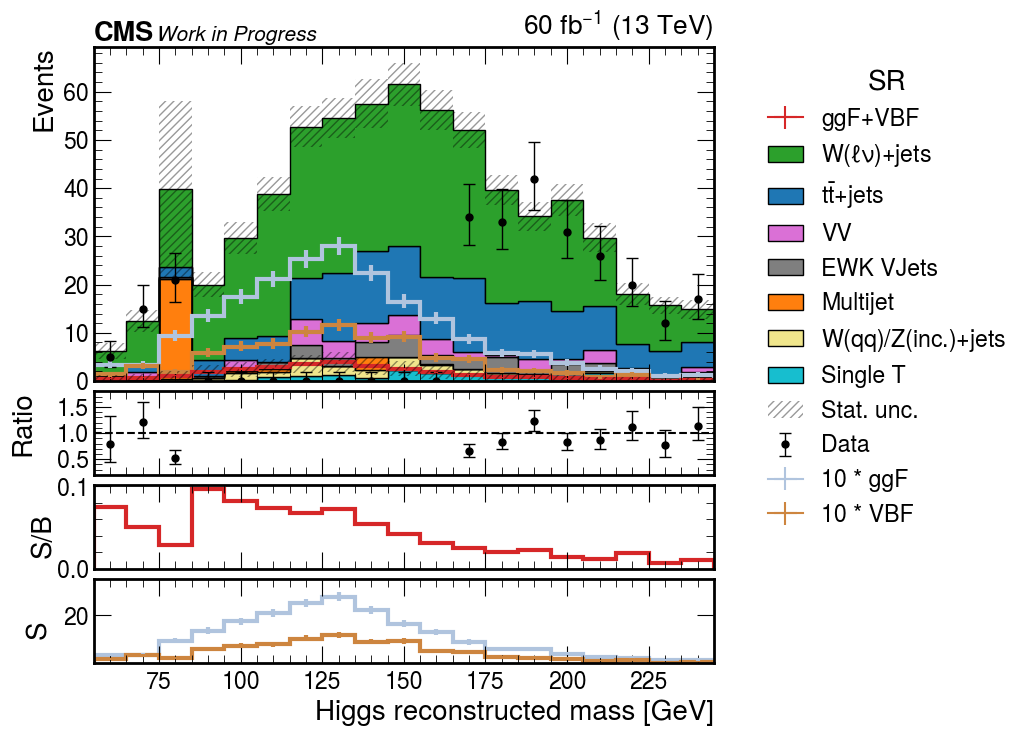

In [215]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=10
    else:
        mult=10
else:
    add_soverb=True
    blind_region=False
    mult=10
    
if "VBF" in categories_sel:
    mult = 5
    
    
from utils import plot_hists
if len(years) > 1:
    from utils import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/SignalRegion/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utils import plot_hists_sb as plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
# get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [64]:
hists

{'rec_higgs_m': Hist(
   StrCategory(['ggF', 'VBF', 'ttH', 'WH', 'ZH', 'QCD', 'WJetsLNu', 'TTbar', 'SingleTop', 'Diboson', 'EWKvjets', 'Data', 'WZQQorDYJets'], growth=True, name='samples'),
   Variable([45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235], name='var', label='Higgs reconstructed mass [GeV]'),
   storage=Double()) # Sum: 1038.332692342047 (1172.7765295977254 with flow)}

In [298]:
hists["rec_higgs_m"][{"samples": sum}].values()[0:2]

array([0.13706524, 2.00155444])

In [463]:
# VBFele + VBFmu + ggF_ele + ggF_mu
(0.75**2 + 1.13**2 + 0.68**2 + 1.02**2)**0.5

1.8281684823888633

In [464]:
# VBF + ggF
(1.35**2 + 1.21**2)**0.5

1.81289823211343

In [471]:
(0.82**2 + 1.24**2)**0.5

1.4866068747318506

In [89]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "WZQQorDYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
#         "ttH": 0, 
#         "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "WZQQorDYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "QCD",
#         "DYJets",
        "WJetsLNu",
#         "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data",
        "WZQQorDYJets",
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(45,210,20)

syst = "UES_down"


a = ax.hist(df["rec_higgs_m"], label="Nominal", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

d = ax.hist(df[f"rec_higgs_m{syst}"], label="down", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

# w = (df[f"rec_higgs_m{syst}"]/df["rec_higgs_m"])
# ax.hist(df[f"rec_higgs_m"], label="(should be down)", weights=df["weight_ele"] * w,
#         bins=bins, lw=1, histtype="step", 
#        )

ax.legend()
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")